In [1]:
import re
from datetime import datetime
from pyspark.sql.functions import monotonically_increasing_id, row_number # for join
from pyspark.sql.window import Window # join

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('assignment') \
    .getOrCreate()

In [2]:
x_train = spark.read.option("sep", "\t").csv("train.data")
y_train = spark.read.csv("train.solution") 

In [3]:
now = datetime.now()
x_train=x_train.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
y_train=y_train.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
dataset = x_train.join(y_train,'row_index').drop("row_index")
print(datetime.now() - now)

0:00:00.301393


## There is partition error, so I tried to use:

x_train.rdd.getNumPartitions()

x_train = x_train.repartition(22)

y_train = x_train.repartition(8)

dataset = dataset.repartition(30)


## However, it doesn't work, so limit row

In [4]:
now = datetime.now()
dataset = dataset.limit(100000)
#dataset.show(5)
print(datetime.now() - now)

0:00:00.004851


In [5]:
now = datetime.now()
dataset = dataset.toPandas()
dataset.to_csv('dataset.csv', index=False, header=False)
print(datetime.now() - now)

0:07:54.762080


## Load small dataset

In [6]:
dataset = spark.read.csv('dataset.csv')

In [7]:
feature = open("feature.name","r", encoding='utf-8').read()
feature = re.sub('[!@#$]', '', feature)
col_name = feature.split("\t")
col_name.append("retweets")

In [8]:
dataset = dataset.toDF(*col_name)
dataset.printSchema()

root
 |-- tweet_id: string (nullable = true)
 |-- username: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- friends: string (nullable = true)
 |-- favorites: string (nullable = true)
 |-- entities: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- urls: string (nullable = true)
 |-- retweets: string (nullable = true)



## Cleaning

In [9]:
from clean import Clean

In [10]:
clean = Clean()

In [11]:
dataset = clean.cleaning(dataset)

root
 |-- followers: double (nullable = true)
 |-- friends: double (nullable = true)
 |-- favorites: double (nullable = true)
 |-- posi_sen: float (nullable = true)
 |-- nega_sen: float (nullable = true)
 |-- count_ent_an: float (nullable = true)
 |-- ent_score: float (nullable = true)
 |-- days: string (nullable = true)
 |-- weeks: double (nullable = false)
 |-- hours: integer (nullable = true)
 |-- q_hours: float (nullable = true)
 |-- retweets: double (nullable = true)

None
0:00:12.089981


In [13]:
dataset.show()

+------------------+------------------+-------------------+--------+--------+------------+----------+----+-----+-----+-------+-------------------+
|         followers|           friends|          favorites|posi_sen|nega_sen|count_ent_an| ent_score|days|weeks|hours|q_hours|           retweets|
+------------------+------------------+-------------------+--------+--------+------------+----------+----+-----+-----+-------+-------------------+
| 2.791690649020118| 2.886490725172482|                0.0|     2.0|    -1.0|         0.0|       0.0| Tue|  0.0|    0|    1.0|                0.0|
| 4.560683591907453| 4.286546283516697| 1.2304489213782739|     1.0|    -4.0|         2.0|-2.8500476| Tue|  0.0|    0|    1.0| 1.1139433523068367|
|3.7005306569785916| 3.286231854028553|                0.0|     2.0|    -1.0|         3.0|-2.7635467| Tue|  0.0|    0|    1.0|                0.0|
| 3.346157302232008|2.9872192299080047|                0.0|     2.0|    -1.0|         2.0|-2.4632268| Tue|  0.0|    0|

## Training

In [16]:
from pyspark.ml.feature import VectorAssembler

In [17]:
fea = VectorAssembler().setInputCols(['followers',"friends","favorites","posi_sen",
                                            "nega_sen","count_ent_an","ent_score","weeks","q_hours"])\
        .setOutputCol("features")
data = fea.transform(dataset)

## Linear Regression

In [18]:
from pyspark.ml.regression import LinearRegression

In [19]:
train, test = data.randomSplit(weights=[0.8,0.2], seed=42)

In [20]:
lr = LinearRegression(featuresCol="features", labelCol='retweets')

In [21]:
now = datetime.now()
lrmodel = lr.fit(train)
print(datetime.now()-now)

0:00:50.648168


In [22]:
pred = lrmodel.transform(test)
pred.select("features","retweets","prediction").show(10)

+--------------------+--------+--------------------+
|            features|retweets|          prediction|
+--------------------+--------+--------------------+
|[0.0,0.0,0.0,1.0,...|     0.0|-0.00963023395065...|
|(9,[3,4,7,8],[1.0...|     0.0|-0.03684810167350511|
|(9,[3,4,8],[1.0,-...|     0.0|-0.03215844047042...|
|(9,[3,4,8],[1.0,-...|     0.0|-0.03831059288964...|
|[0.0,0.0,0.0,1.0,...|     0.0| 0.05147787570134586|
|[0.0,0.0,0.0,1.0,...|     0.0|-0.03501733933063832|
|[0.0,0.0,0.0,1.0,...|     0.0|0.015612736874335745|
|[0.0,0.0,0.0,1.0,...|     0.0|0.008029673364278296|
|[0.0,0.0,0.0,2.0,...|     0.0|-0.01603075050056...|
|[0.0,0.0,0.0,2.0,...|     0.0|-0.02310754013260...|
+--------------------+--------+--------------------+
only showing top 10 rows



## Evaluate

In [23]:
from pyspark.ml.evaluation import RegressionEvaluator

In [24]:
regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="retweets",metricName='rmse')

In [25]:
rmse = regressionEvaluator.evaluate(pred)
print(f"RMSE is {rmse:.1f}")

RMSE is 0.2


In [26]:
r2 = regressionEvaluator.setMetricName('r2').evaluate(pred)
print(f"R2 is {r2}")

R2 is 0.9087026295443564


## Random Forest

In [27]:
from pyspark.ml.regression import RandomForestRegressor

In [28]:
train, test = data.randomSplit(weights=[0.8,0.2], seed=42)

In [29]:
rf = RandomForestRegressor(labelCol="retweets", maxBins=100, seed=42)

In [30]:
rfmodel = rf.fit(train)

In [31]:
pred = rfmodel.transform(test)

## Evaluate

In [32]:
regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="retweets",metricName='rmse')

In [33]:
rmse = regressionEvaluator.evaluate(pred)
print(f"RMSE is {rmse:.1f}")

RMSE is 0.3


In [34]:
r2 = regressionEvaluator.setMetricName('r2').evaluate(pred)
print(f"R2 is {r2}")

R2 is 0.8543836339798685


## Cross Validation

In [35]:
from pyspark.ml.tuning import ParamGridBuilder
paramGrid = (ParamGridBuilder()
    .addGrid(rf.maxDepth, [2, 4, 6])
    .addGrid(rf.numTrees, [10, 100])
    .build())
evaluator = RegressionEvaluator(labelCol="retweets",
    predictionCol="prediction",
    metricName="r2")

In [36]:
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=rf,
 evaluator=evaluator,
 estimatorParamMaps=paramGrid,
 numFolds=3,
 seed=42)
cvModel = cv.fit(test)

In [37]:
list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))

[({Param(parent='RandomForestRegressor_081a5691a33c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='RandomForestRegressor_081a5691a33c', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
  0.7293514244130832),
 ({Param(parent='RandomForestRegressor_081a5691a33c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='RandomForestRegressor_081a5691a33c', name='numTrees', doc='Number of trees to train (>= 1).'): 100},
  0.6826560721704035),
 ({Param(parent='RandomForestRegressor_081a5691a33c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='RandomForestRegressor_081a5691a33c', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
  0.8258572679017

## Tensorflow

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import tensorflow.keras.backend as K

In [39]:
## toPandas and save it
now = datetime.now()
df = dataset.toPandas()
df.to_csv('tensor.csv', index=False)
print(datetime.now() - now)

0:00:18.151411


In [40]:
## read in Pandas
df = pd.read_csv('tensor.csv')
df.head()

,followers,friends,favorites,posi_sen,nega_sen,count_ent_an,ent_score,days,weeks,hours,q_hours,retweets
0,2.791691,2.886491,0.000000,2.0,-1.0,0.0,0.000000,Tue,0.0,0,1.0,0.000000
1,4.560684,4.286546,1.230449,1.0,-4.0,2.0,-2.850048,Tue,0.0,0,1.0,1.113943
2,3.700531,3.286232,0.000000,2.0,-1.0,3.0,-2.763547,Tue,0.0,0,1.0,0.000000
3,3.346157,2.987219,0.000000,2.0,-1.0,2.0,-2.463227,Tue,0.0,0,1.0,0.000000
4,3.954677,3.693991,1.949390,2.0,-1.0,2.0,-2.622788,Tue,0.0,0,1.0,1.414973


In [41]:
del df['days'] # delete string value 
del df['hours'] # this is not usefull due to q_hours

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   followers     100000 non-null  float64
 1   friends       100000 non-null  float64
 2   favorites     100000 non-null  float64
 3   posi_sen      100000 non-null  float64
 4   nega_sen      100000 non-null  float64
 5   count_ent_an  100000 non-null  float64
 6   ent_score     100000 non-null  float64
 7   weeks         100000 non-null  float64
 8   q_hours       100000 non-null  float64
 9   retweets      100000 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB


In [43]:
x = df.iloc[:, 0:-1].values.astype(float)
y = df.iloc[:, -1].values.astype(float)

In [44]:
sc = StandardScaler()
x = sc.fit_transform(x)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [46]:
# https://stackoverflow.com/questions/42665359/how-do-you-compute-accuracy-in-a-regression-model-after-rounding-predictions-to
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [47]:
def Model():
    
    model = Sequential([
        Dense(90, input_shape=(9,), activation="relu"),
        BatchNormalization(),
        Dense(162, activation='relu'),
        BatchNormalization(),
        Dense(162, activation='relu'),
        BatchNormalization(),
        Dense(63, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(1)
        
    ])
    
#     model.compile(optimizer = 'Nadam', loss = 'mse', metrics = ['accuracy'])
    model.compile(optimizer = 'adam', loss = 'mse', metrics = [soft_acc])
    return model

In [48]:
model = Model()
history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True,
                         validation_data=(X_test,y_test), 
                         epochs=100, batch_size=1000)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/64 [============================>.] - ETA: 0s - loss: 0.3372 - soft_acc: 0.7178WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fcac4816620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach th

64/64 [==============================] - 1s 19ms/step - loss: 0.0386 - soft_acc: 0.9054 - val_loss: 0.0530 - val_soft_acc: 0.8931
Epoch 46/100
64/64 [==============================] - 1s 19ms/step - loss: 0.0392 - soft_acc: 0.9053 - val_loss: 0.0510 - val_soft_acc: 0.8934
Epoch 47/100
64/64 [==============================] - 1s 19ms/step - loss: 0.0385 - soft_acc: 0.9053 - val_loss: 0.0521 - val_soft_acc: 0.8895
Epoch 48/100
64/64 [==============================] - 1s 19ms/step - loss: 0.0386 - soft_acc: 0.9052 - val_loss: 0.0515 - val_soft_acc: 0.8928
Epoch 49/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0387 - soft_acc: 0.9055 - val_loss: 0.0527 - val_soft_acc: 0.8916
Epoch 50/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0388 - soft_acc: 0.9054 - val_loss: 0.0541 - val_soft_acc: 0.8897
Epoch 51/100
64/64 [==============================] - 1s 20ms/step - loss: 0.0382 - soft_acc: 0.9059 - val_loss: 0.0522 - val_soft_acc: 0.8907
Epoch 52/100

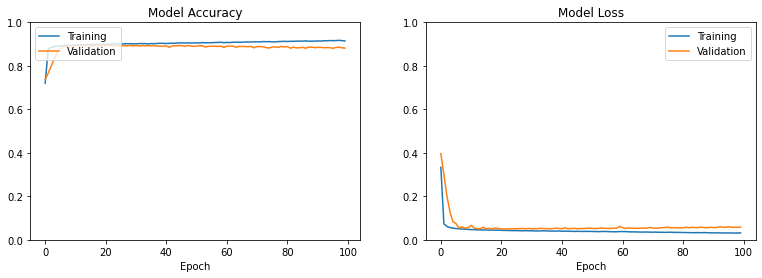

In [49]:
%matplotlib inline

def plots(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

    # plot accuracy
    ax1.plot(acc, label='Training')
    if val_acc is not None:
        ax1.plot(val_acc, label='Validation')

    ax1.set_xlabel('Epoch')
    ax1.set_title('Model Accuracy')
    ax1.legend(loc='upper left')
    ax1.set_ylim([0,1])

    # plot loss
    ax2.plot(loss, label='Training')
    if val_loss is not None:
        ax2.plot(val_loss, label='Validation')

    ax2.set_xlabel('Epoch')
    ax2.set_title('Model Loss')
    ax2.legend(loc='upper right')
    ax2.set_ylim([0,1])

    plt.show()

plt.rcParams["figure.figsize"] = (13,4)
plots(history.history["soft_acc"],history.history['val_soft_acc'],
      history.history["loss"],history.history['val_loss'])